# 2D Random Walker

The Random Walk on a 2D surface with periodic boundary conditions along one direction is explored in this work. 

- We first simulate the many random walks for $\textbf{nSteps}$ for fixed dimension of $X,Y$. 

- Then we trace out the Y-values and try to find the distribution of the random variable x by generating a list of all X-values across runs. 

- This yields the possible probability ditribution. 

The Following are the parameters that are involved for this study:
- $nSteps$: No. of steps the walker takes in each walk
- $nRuns$: No.of Random Walks of nSteps over which we average
- $(X,Y)$ : The Boundary conditions for the cylindrical surface
- $P(x)$ : Probability of finding the particle x that we find after tracing values of y


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing some specific packages 
import random
import collections
import csv
import itertools as it
import scipy.interpolate
import scipy.stats

# Plot and typeface options for matplotlib
mpl.rc('font', size=14)
mpl.rc('text', usetex=True)
mpl.rc('font', family='sans-serif', serif='Times New Roman')


def takeStep(extraChoices=[]):
    stepChoices = [[1,0],[-1,0],[0,1],[0,-1]]
    return random.choice(stepChoices)


def normalMove(Loc,bcX,bcY):
    newLoc = [bcX+1,bcY+1]
    while abs(newLoc[0])> bcX or abs(newLoc[1])> bcY:
        step = takeStep()
        newLoc = [Loc[0]+step[0],Loc[1]+step[1]]
    return newLoc,step


def periodicMove(Loc,bcX,bcY):
    newLoc = [bcX+1,bcY+1]
    while abs(newLoc[0])> bcX :
        step = takeStep()
        newLoc = [Loc[0]+step[0],Loc[1]+step[1]]   
        if abs(newLoc[1])== bcY+1:
            y = newLoc[1]
            newLoc[1] = -1*(abs(y)-1)* int(y/abs(y))        
    return newLoc,step

def Walk(nSteps,bcX,bcY):
    pathChoices = []
    path = []
    startLoc = [0,0]
    Loc = startLoc
    for i in range(nSteps):
        Loc,step = periodicMove(Loc,bcX,bcY)
        path.append(Loc)
        pathChoices.append(step)
    return tuple(Loc)

def dict_to_csv(dictionary,title,xhead='',yhead=''):
        with open(title+'.csv', 'w') as f:
                f.write(xhead+'\t'+yhead+'\n')
                [f.write('{0}\t{1}\n'.format(key, value)) for key, value in dictionary.items()]

def runExperiment(nSteps,runs,bcX,bcY):
    distribution = []
    for run in range(runs):
        distribution.append(Walk(nSteps,bcX,bcY))
    #print(distribution)    
    collectPaths = dict(collections.Counter(distribution))
    title = 'nSteps'+str(nSteps)+'_runs'+str(runs)+'_X'+str(bcX)+'_Y'+str(bcY)
    dict_to_csv(collectPaths,title,xhead = '(x,y)',yhead='P[(x,y)]')
    
    return distribution

def alongAxes(distribution,Y):
    distX = [x[0] for x in distribution  if x[1]==Y ]
    collectPaths = dict(collections.Counter(distX))
    probabilityDistribution = {k: v /len(distribution)
                               for k, v in collectPaths.items()}
    return distX,probabilityDistribution
    
def traceY(distribution,title):
    distX = [x[0] for x in distribution]
    collectPaths = dict(collections.Counter(distX))
    probabilityDistribution = {k: v /(total) 
                               for total in (sum(collectPaths.values()),) 
                               for k, v in collectPaths.items()}
    dict_to_csv(probabilityDistribution ,title+'_tracedY',xhead = 'x',yhead='P(x) traced over Y')
    return distX,probabilityDistribution


    
def plotDistribution(probabilityDistribution,title='',textstr='', limits=False, xlim= (), ylim=() ):
    x, y = zip(*sorted(probabilityDistribution.items())) # unpack a list of pairs into two tuples
    figs, axs = plt.subplots()
    axs.scatter(x,y)
    axs.set_xlabel('x',fontsize=16)
    axs.set_ylabel('P(x)',fontsize=16)
    if limits==True:
        axs.set_xlim(xlim[0],xlim[1])
        axs.set_ylim(ylim[0],ylim[1])
    plt.title(title)
    plt.gcf().text(0.0, -0.1, textstr, fontsize=14)
    #plt.savefig(title+'.png',dpi=200)
    plt.show()  
    return(x,y)

def nonGaussianParameter(distribution):
    second_moment = scipy.stats.moment(distribution, moment =2)
    fourth_moment = scipy.stats.moment(distribution, moment =4)
    nGP = (3* fourth_moment)/(5* (second_moment)**2) - 1
    return nGP
    
    

def testDist(x,y,distribution):
    #f = scipy.interpolate.interp1d(x,y)
    #a = np.linspace(-25,25,1000)  
    #print(scipy.stats.kstest(f(a),'norm',N=100))
    #plt.plot(a,f(a))
    var = np.var(distribution)
    std = np.std(distribution)
    ngp = nonGaussianParameter(distribution)
    print('Non-Gaussian Parameter:', ngp)
    print('Variance:',var)
    print('Standard Deviation:',std)
    return(std,var,ngp)

def calculation(nSteps,runs,bcX,bcY):    
    title = ('nSteps'+str(nSteps) +'_runs'+str(runs) 
             +'_X'+str(bcX)+'_Y'+str(bcY))
    textstr = ('nSteps:'+str(nSteps) 
               + '\n'+'_runs:' +str(runs)
               + '\n'+'bcX:'+str(bcX)+'  bcY:'+str(bcY))
    distribution = runExperiment(nSteps,runs,bcX,bcY)

    #The probability dsitribution P(x) by tracing out Y values
    traceDistX, traceProbDistX = traceY(distribution,title)
    x,y  = plotDistribution(traceProbDistX, title +'_traced')
    std,var,ngp  = testDist(x,y,traceDistX)
    
    #The untraced distribution P(X) along Y=0
    alongAxesDistZ, alongAxesProbDistZ = alongAxes(distribution,0)
    Xz, Yz = plotDistribution(alongAxesProbDistZ, title+'_alongYz')
    stdZ,varZ,ngpZ = testDist(Xz, Yz,alongAxesDistZ )
    dict_to_csv(alongAxesProbDistZ ,title+'_alongYz',xhead = 'x',yhead='P(x)_alongYz')
    
    if bcY>0:
        #The untraced distribution P(X) along Y=1
        alongAxesDistU1, alongAxesProbDistU1 = alongAxes(distribution,1) 
        Xu1,Yu1  = plotDistribution(alongAxesProbDistU1, title+'_alongYu1')
        stdU1,varU1,ngpU1 = testDist(Xu1,Yu1,alongAxesDistU1)
        dict_to_csv(alongAxesProbDistU1,title+'_alongYu1',xhead = 'x',yhead='P(x)_alongYu1')
    
        #The untraced distribution P(X) along Y=-1
        alongAxesDistD1, alongAxesProbDistD1 = alongAxes(distribution,-1)
        Xd1,Yd1  = plotDistribution(alongAxesProbDistD1, title+'_alongYd1')
        stdD1,varD1,ngpD1 = testDist(Xd1,Yd1,alongAxesDistD1)
        dict_to_csv(alongAxesProbDistD1,title+'_alongYd1',xhead = 'x',yhead='P(x)_alongYd1')

## Calculations
Lets run some calculation and do some statistics for a 2d Random walk.

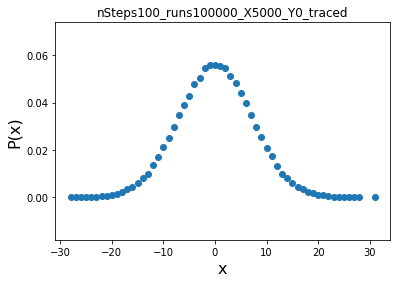

Non-Gaussian Parameter: 0.7719586927212547
Variance: 50.02922388760001
Standard Deviation: 7.07313395091596


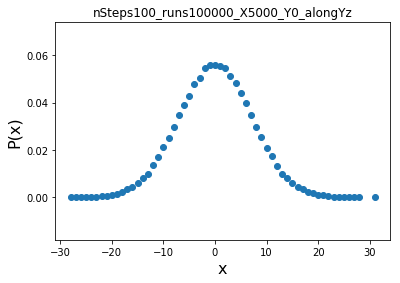

Non-Gaussian Parameter: 0.7719586927212547
Variance: 50.02922388760001
Standard Deviation: 7.07313395091596


In [2]:
calculation(100,100000,5000,0)

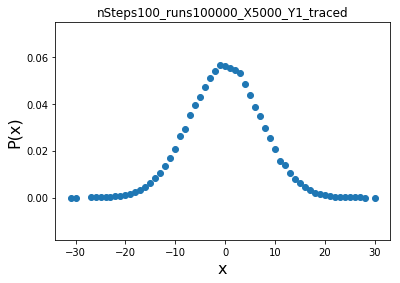

Non-Gaussian Parameter: 0.7909831080674676
Variance: 50.1449126076
Standard Deviation: 7.0813072668540515


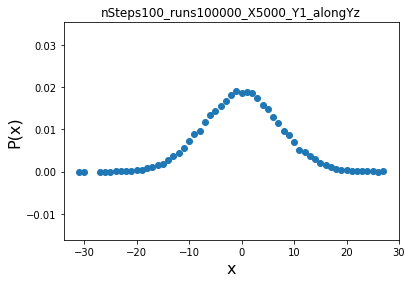

Non-Gaussian Parameter: 0.7764501708846268
Variance: 49.90613275283125
Standard Deviation: 7.064427277057302


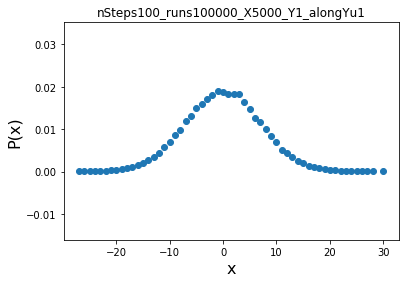

Non-Gaussian Parameter: 0.8344235809104905
Variance: 50.42067823310714
Standard Deviation: 7.100751948428218


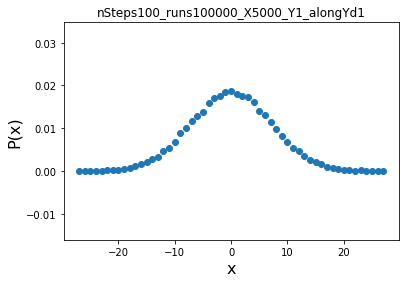

Non-Gaussian Parameter: 0.7604831586837242
Variance: 50.10489363918207
Standard Deviation: 7.0784810262641855


In [3]:
calculation(100,100000,5000,1)

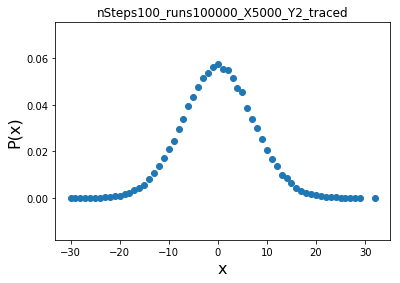

Non-Gaussian Parameter: 0.7867311206620013
Variance: 49.850875647100004
Standard Deviation: 7.0605152536553595


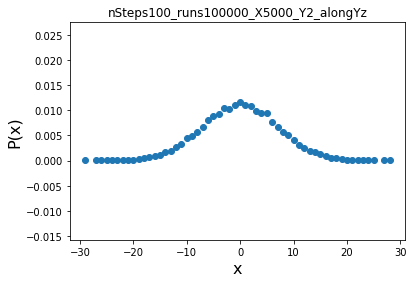

Non-Gaussian Parameter: 0.7923392001934253
Variance: 50.19597969337803
Standard Deviation: 7.084912116136517


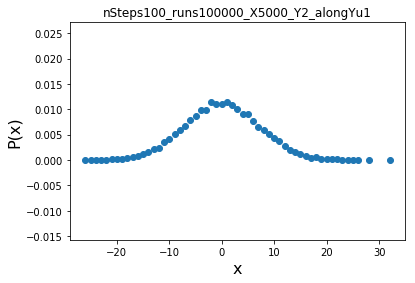

Non-Gaussian Parameter: 0.7892823600601606
Variance: 49.987139446765966
Standard Deviation: 7.0701583749422445


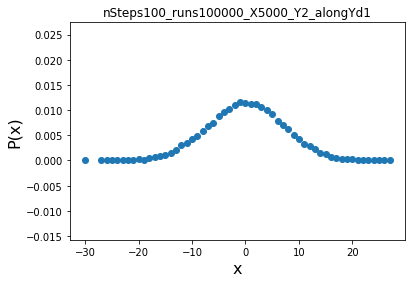

Non-Gaussian Parameter: 0.7803587625898583
Variance: 49.66730090659854
Standard Deviation: 7.047503168257432


In [4]:
calculation(100,100000,5000,2)

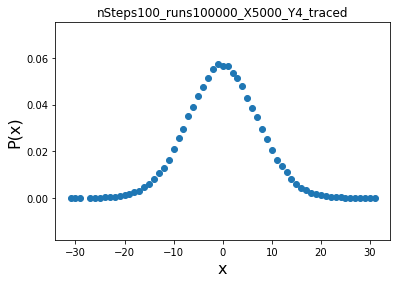

Non-Gaussian Parameter: 0.8084141257036224
Variance: 50.1797021916
Standard Deviation: 7.083763278907617


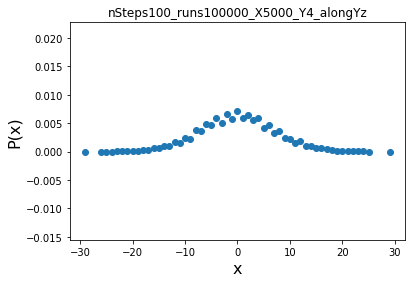

Non-Gaussian Parameter: 0.8289873129181828
Variance: 50.19782165392469
Standard Deviation: 7.085042106715012


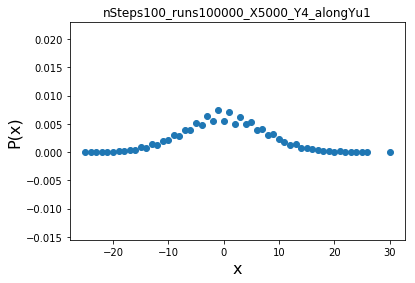

Non-Gaussian Parameter: 0.8027948822800852
Variance: 48.7938305940796
Standard Deviation: 6.985258090727901


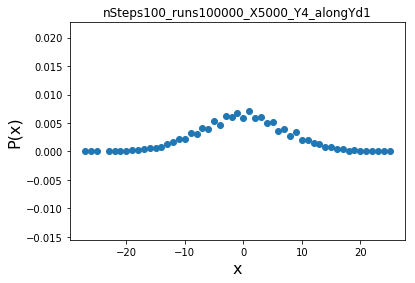

Non-Gaussian Parameter: 0.7872366973951459
Variance: 49.68178249273601
Standard Deviation: 7.048530520096796


In [5]:
calculation(100,100000,5000,4)

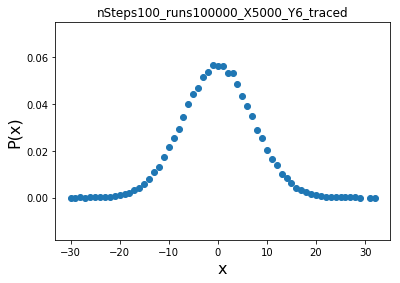

Non-Gaussian Parameter: 0.805367849201279
Variance: 50.18925439750001
Standard Deviation: 7.084437479256911


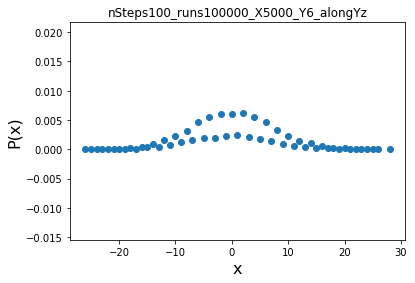

Non-Gaussian Parameter: 0.8166586053535281
Variance: 50.561731673937444
Standard Deviation: 7.110677300647066


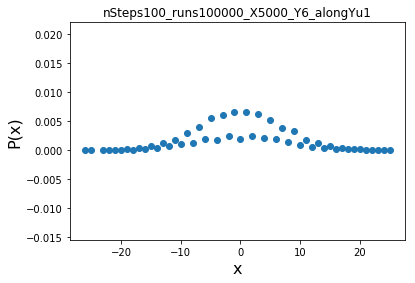

Non-Gaussian Parameter: 0.7945793170882622
Variance: 49.64420860201415
Standard Deviation: 7.045864645450845


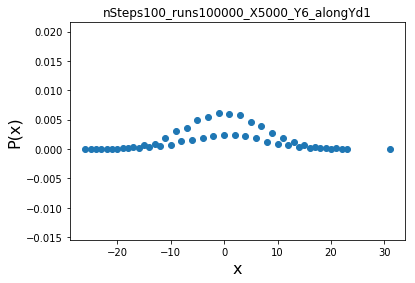

Non-Gaussian Parameter: 0.8134606608321808
Variance: 50.30653291071681
Standard Deviation: 7.092709842557837


In [6]:
calculation(100,100000,5000,6)

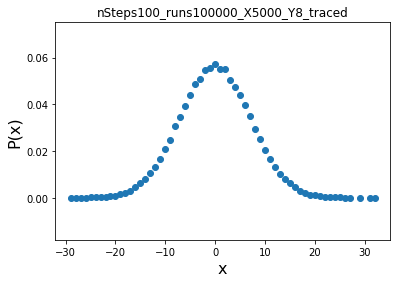

Non-Gaussian Parameter: 0.8027105283366709
Variance: 50.0690006599
Standard Deviation: 7.075945213178237


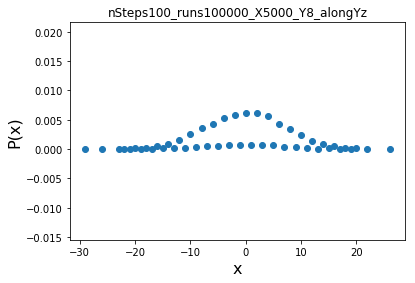

Non-Gaussian Parameter: 0.7529186412692643
Variance: 50.17715334165258
Standard Deviation: 7.083583368723247


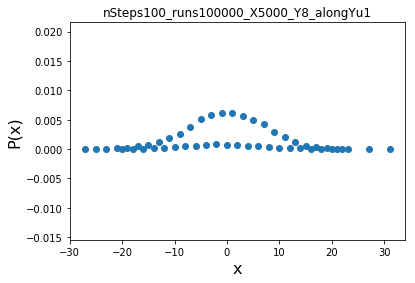

Non-Gaussian Parameter: 0.8072799380776319
Variance: 50.10771870939686
Standard Deviation: 7.078680576872844


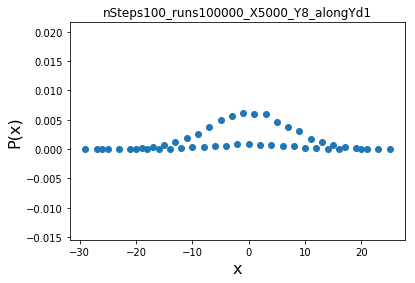

Non-Gaussian Parameter: 0.8405384723001263
Variance: 51.177564388595314
Standard Deviation: 7.153849620211157


In [7]:
calculation(100,100000,5000,8)

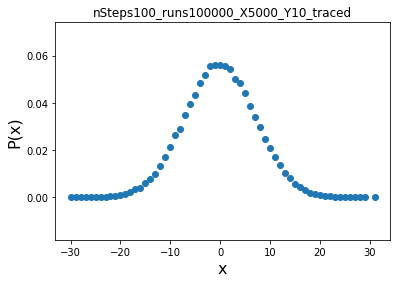

Non-Gaussian Parameter: 0.7910846076444735
Variance: 49.844663497499994
Standard Deviation: 7.060075318118072


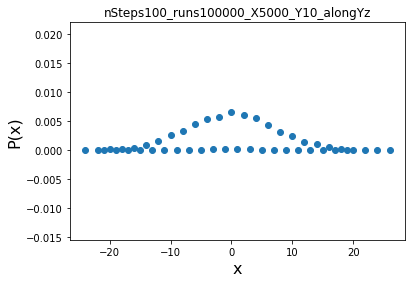

Non-Gaussian Parameter: 0.7355539117990402
Variance: 49.11676747411386
Standard Deviation: 7.008335570883707


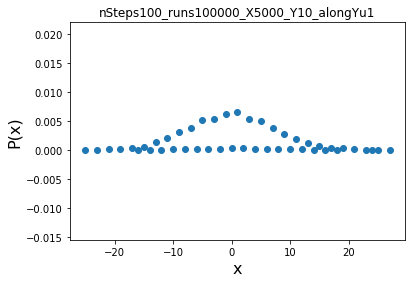

Non-Gaussian Parameter: 0.8002813988746187
Variance: 51.11547026208197
Standard Deviation: 7.149508393035284


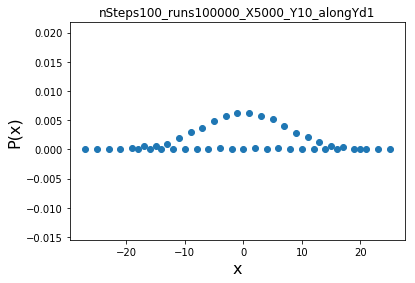

Non-Gaussian Parameter: 0.7831379650445995
Variance: 50.16505651003925
Standard Deviation: 7.082729453398545


In [22]:
calculation(100,100000,5000,10)

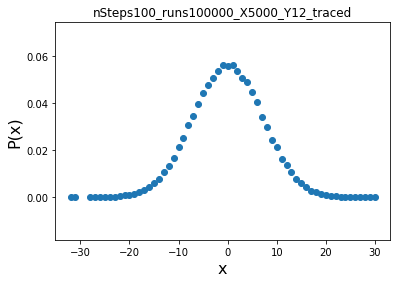

Non-Gaussian Parameter: 0.8010664153855438
Variance: 50.1576638879
Standard Deviation: 7.082207557527526


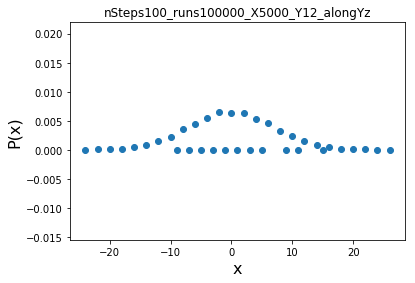

Non-Gaussian Parameter: 0.8061191772433731
Variance: 49.615974222834424
Standard Deviation: 7.043860746979203


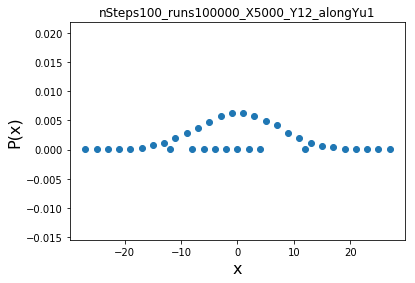

Non-Gaussian Parameter: 0.8292838172444492
Variance: 50.687030562980446
Standard Deviation: 7.119482464546173


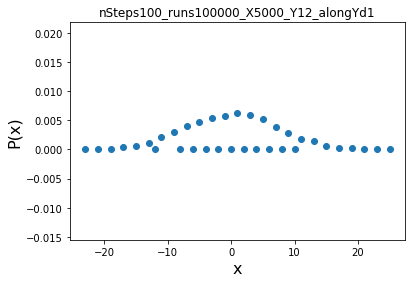

Non-Gaussian Parameter: 0.6942428440628288
Variance: 50.1327584866763
Standard Deviation: 7.080449031429878


In [8]:
calculation(100,100000,5000,12)

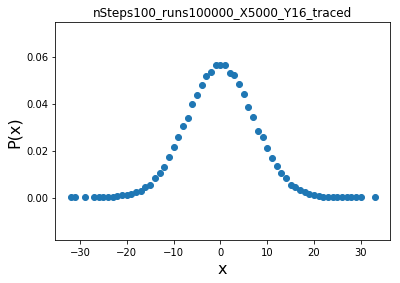

Non-Gaussian Parameter: 0.7889660275470982
Variance: 50.076300703600005
Standard Deviation: 7.076461029610776


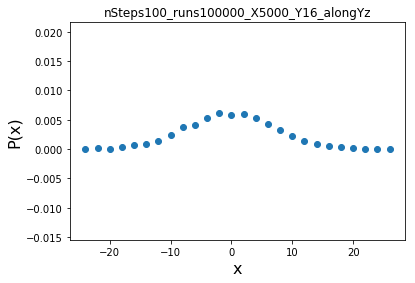

Non-Gaussian Parameter: 0.7922762779922252
Variance: 51.60802519276034
Standard Deviation: 7.183872576317062


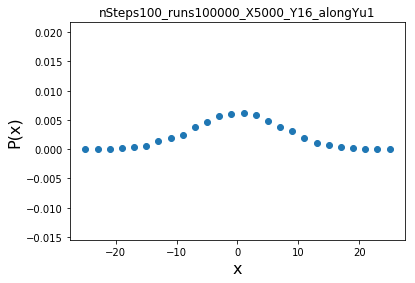

Non-Gaussian Parameter: 0.760352210093832
Variance: 50.94972891734531
Standard Deviation: 7.137907880979224


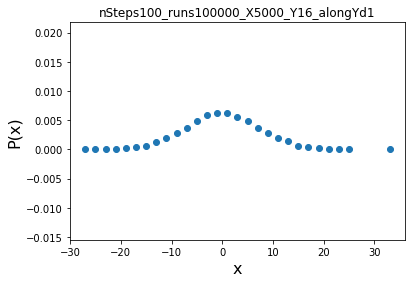

Non-Gaussian Parameter: 0.8525299079304152
Variance: 50.60280946834654
Standard Deviation: 7.113565172847336


In [9]:
calculation(100,100000,5000,16)

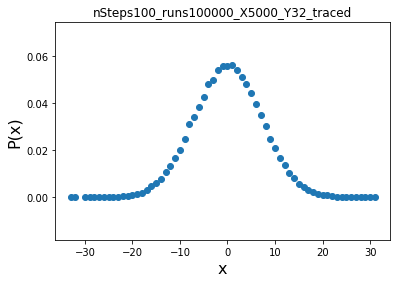

Non-Gaussian Parameter: 0.7940631695160267
Variance: 50.3365247356
Standard Deviation: 7.094823798770481


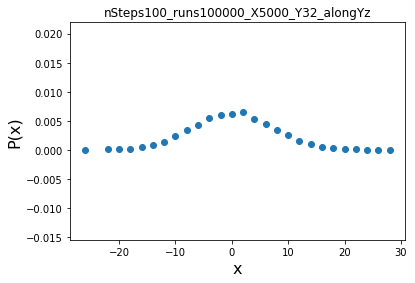

Non-Gaussian Parameter: 0.7907266142479834
Variance: 49.72120287932946
Standard Deviation: 7.0513263205817855


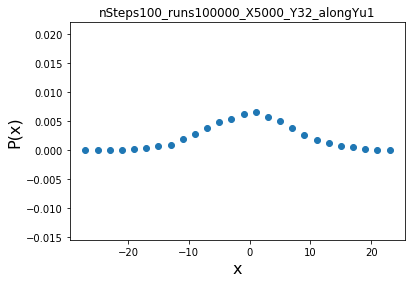

Non-Gaussian Parameter: 0.8267657203232404
Variance: 50.914709630073446
Standard Deviation: 7.135454409501433


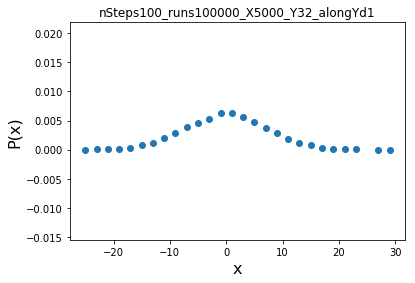

Non-Gaussian Parameter: 0.7727140998191209
Variance: 50.42718715144838
Standard Deviation: 7.10121025962817


In [10]:
calculation(100,100000,5000,32)

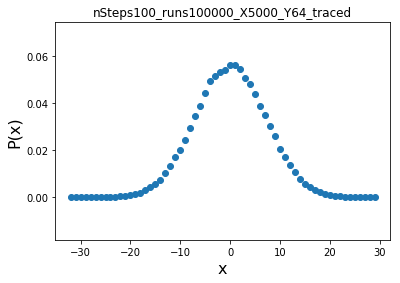

Non-Gaussian Parameter: 0.7990211233452715
Variance: 50.3104654716
Standard Deviation: 7.092987062697915


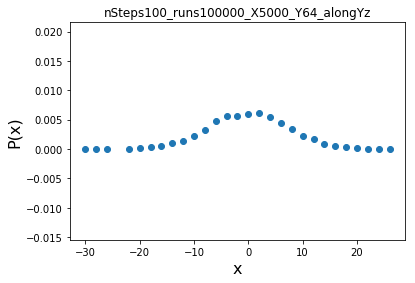

Non-Gaussian Parameter: 0.793572976790172
Variance: 52.309865648464495
Standard Deviation: 7.232555955432664


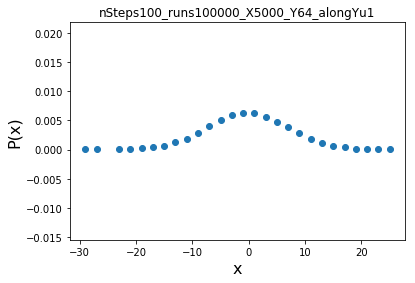

Non-Gaussian Parameter: 0.848589234213692
Variance: 50.47924091339289
Standard Deviation: 7.104874447405309


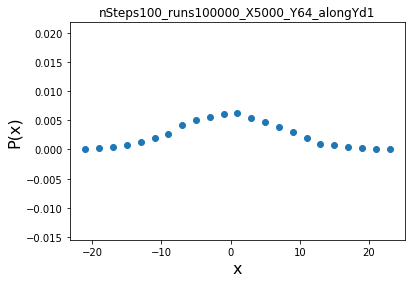

Non-Gaussian Parameter: 0.7268195051312176
Variance: 51.78857859610363
Standard Deviation: 7.196428183210309


In [11]:
calculation(100,100000,5000,64)

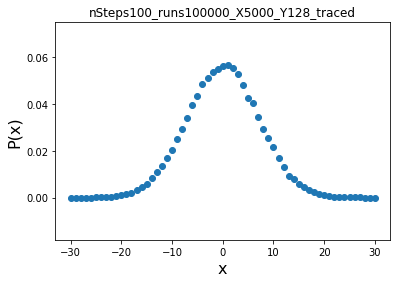

Non-Gaussian Parameter: 0.7959701818682094
Variance: 50.07730789749999
Standard Deviation: 7.076532194337845


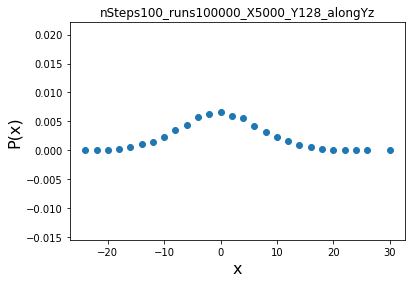

Non-Gaussian Parameter: 0.8579890455815129
Variance: 49.946848634274616
Standard Deviation: 7.067308443408609


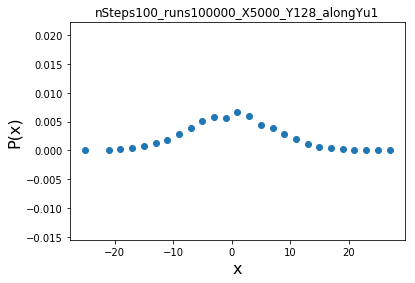

Non-Gaussian Parameter: 0.754398503163376
Variance: 50.46905398565651
Standard Deviation: 7.104157514136107


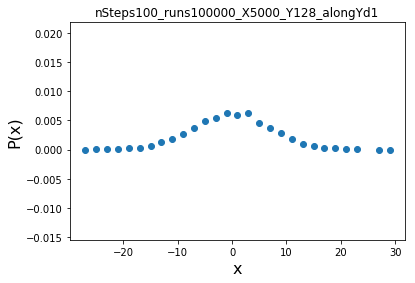

Non-Gaussian Parameter: 0.8393096997836584
Variance: 49.42438317799879
Standard Deviation: 7.030247732334813


In [12]:
calculation(100,100000,5000,128)

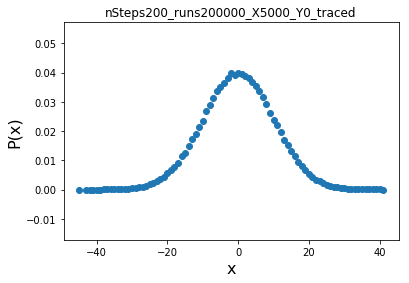

Non-Gaussian Parameter: 0.7928193932446916
Variance: 99.77390650309998
Standard Deviation: 9.988688928137666


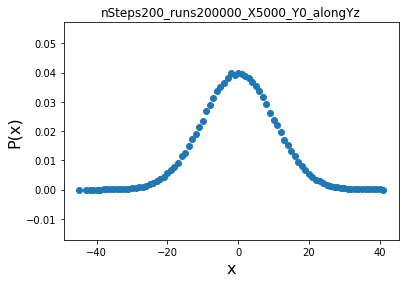

Non-Gaussian Parameter: 0.7928193932446916
Variance: 99.77390650309998
Standard Deviation: 9.988688928137666


In [13]:
calculation(200,200000,5000,0)